Analysis the output of filterTGapsMetric

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def to_array(x):
    'converters to convert csv string to numpy array, used to load csv file'
    arrstr = x.replace('[','').replace(']', '')
    arr = np.fromstring(arrstr, sep=' ')
    return arr


In [8]:
def cal_diffmat(df, night=[0, 400]):
    "calculate time gaps from visit timeCol of two filters"
    # # check start MJD is same as in the database
    startMJD = 59853.985644 + night[0]
    endMJD = 59853.985644 + night[1]
    t_f0 = df['t_f0'] [ (df['t_f0']>=startMJD) & (df['t_f0']<=endMJD) ]
    t_f1 = df['t_f1'] [ (df['t_f1']>=startMJD) & (df['t_f1']<=endMJD) ]
    
    t_f0 = t_f0.reshape((len(t_f0), 1))
    t_f1 = t_f1.reshape((len(t_f1), 1))
    
    diffmat = np.abs( np.subtract(t_f0, t_f1.T) )
    
    return diffmat


In [9]:
def cal_dT(df):
    
    if df.f0==df.f1:
        # get only triangle part
        dt_tri = np.tril(df['diffmat'], -1)
        dT = dt_tri[dt_tri!=0]    # flatten lower triangle 

    else:
        dT = df['diffmat'].flatten()
    
    return dT


In [269]:
def KL_div(px, qx):
    '''calculate KL divergences D(P||Q)'''
    kl = np.sum( px * np.log(px / qx) )
    return kl


In [349]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    values = values + 0.00001  # make each element non-zero
    prob = (values) / values.sum()  
    
    prob_uni = np.ones( len(prob) ) / len(prob)
    
    return KL_div(prob_uni, prob)


In [303]:
values = np.zeros(99) * 10

In [304]:
values += 0.0000001  # make each element non-zero
prob = (values) / values .sum()  

prob_uni = np.ones( len(prob) ) / len(prob)
    

loaded  data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1
CPU times: user 40.5 s, sys: 186 ms, total: 40.7 s
Wall time: 40.7 s


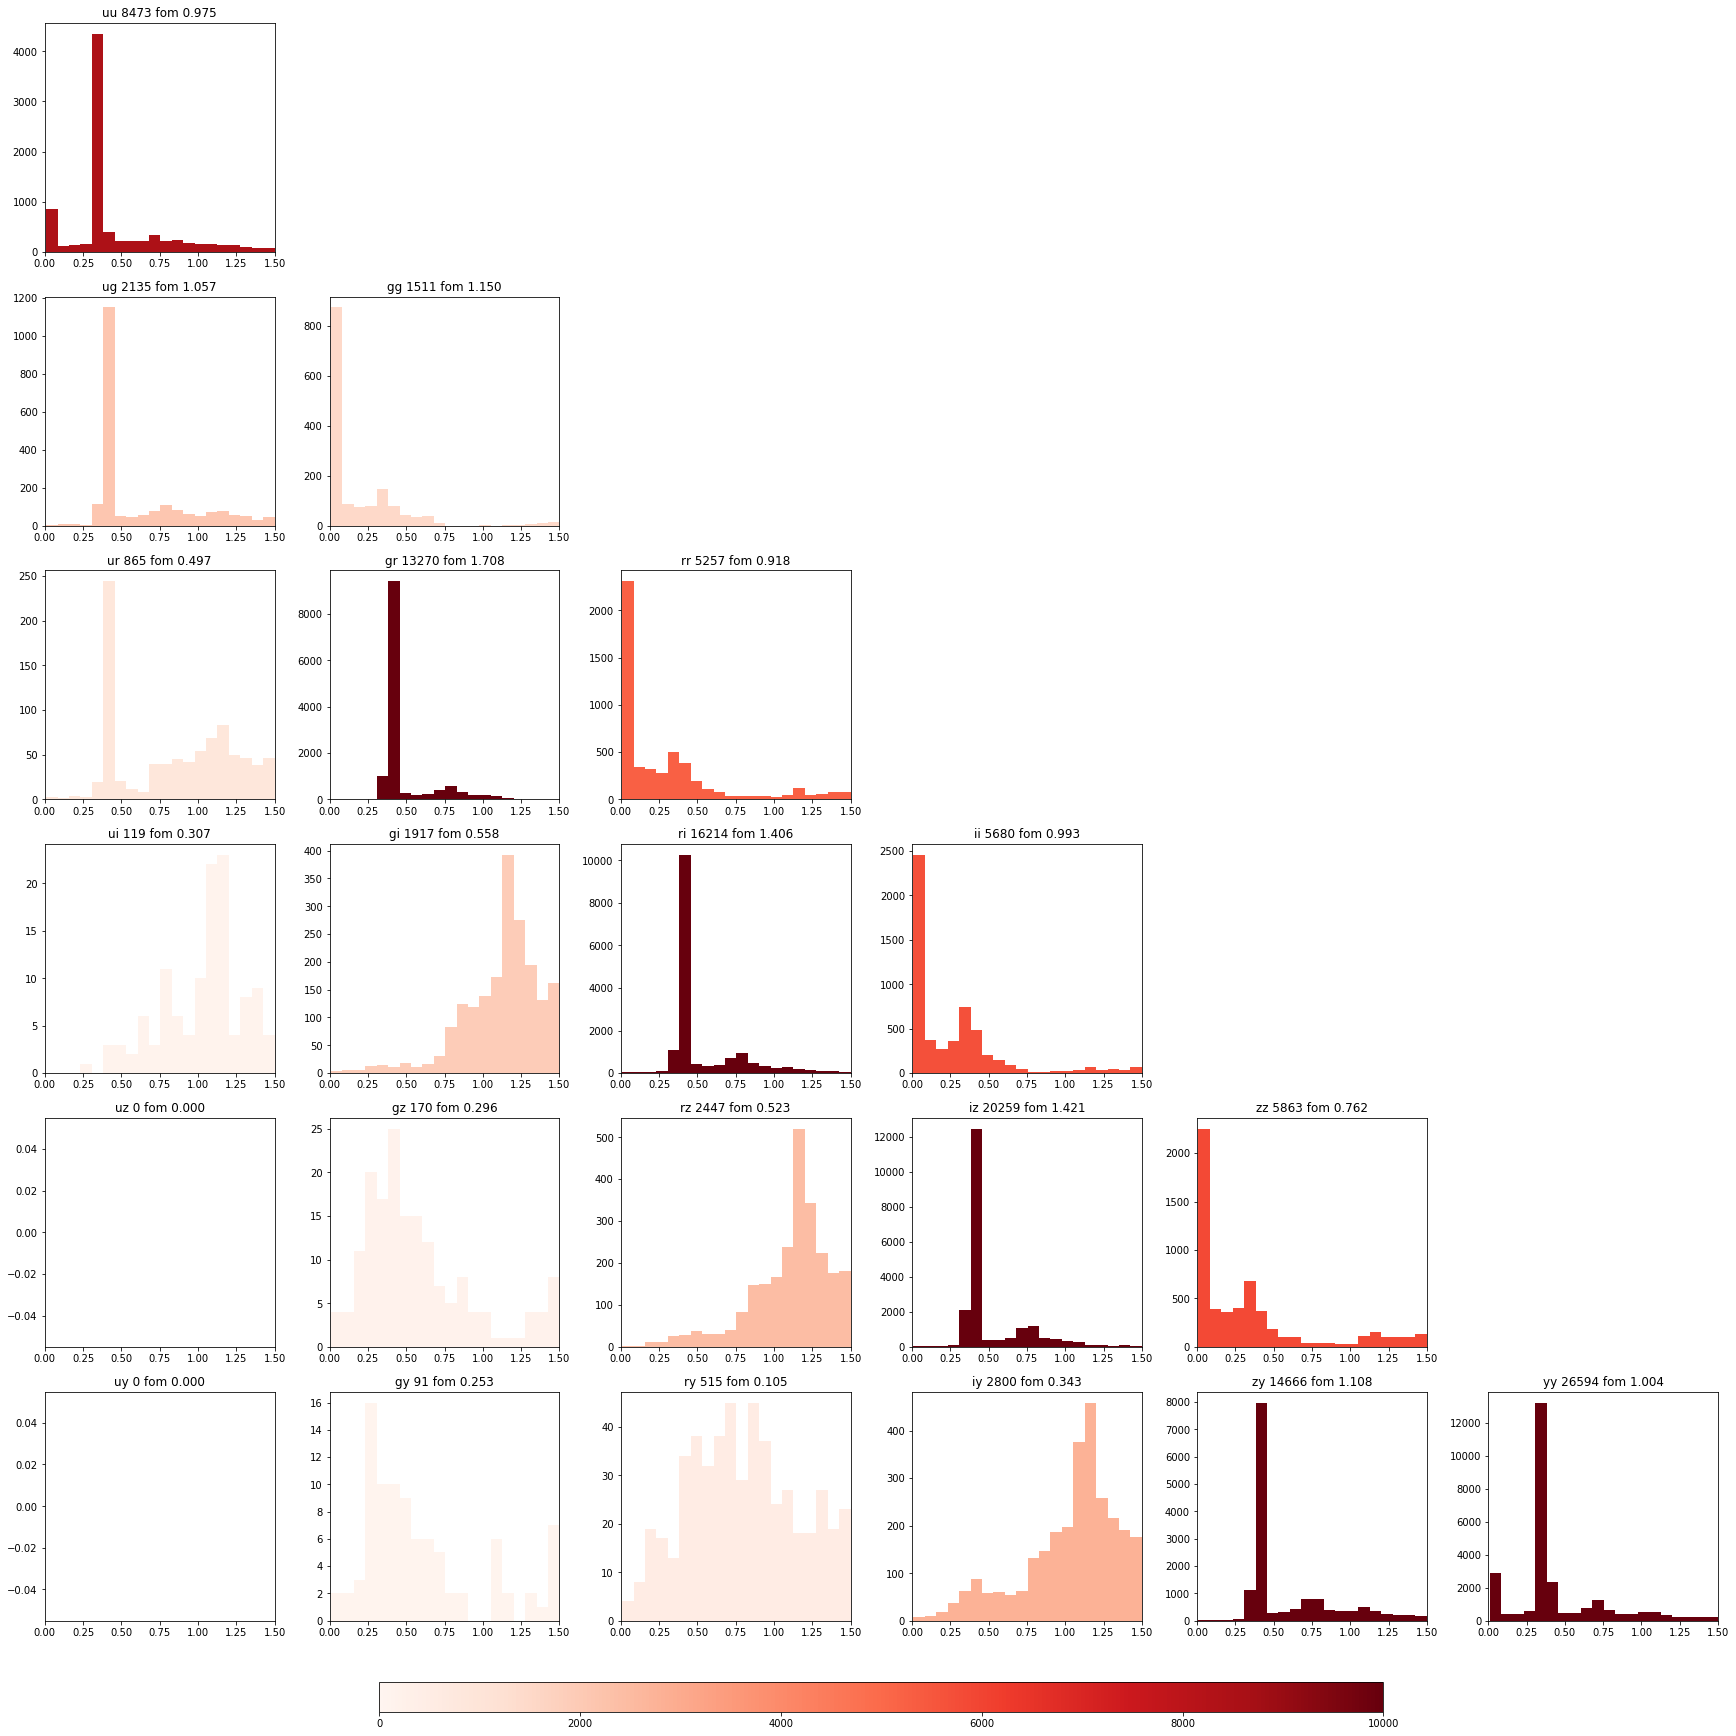

In [21]:
%%time

filename = 'data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1'

# figure of merit, using KL divergence 
plot_hist_FOM(filename=filename, night=[0,400], tmin=0, tmax=1.5, vmax=10000, bins=20 )


loaded  data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1
CPU times: user 1min 19s, sys: 41.3 s, total: 2min
Wall time: 2min


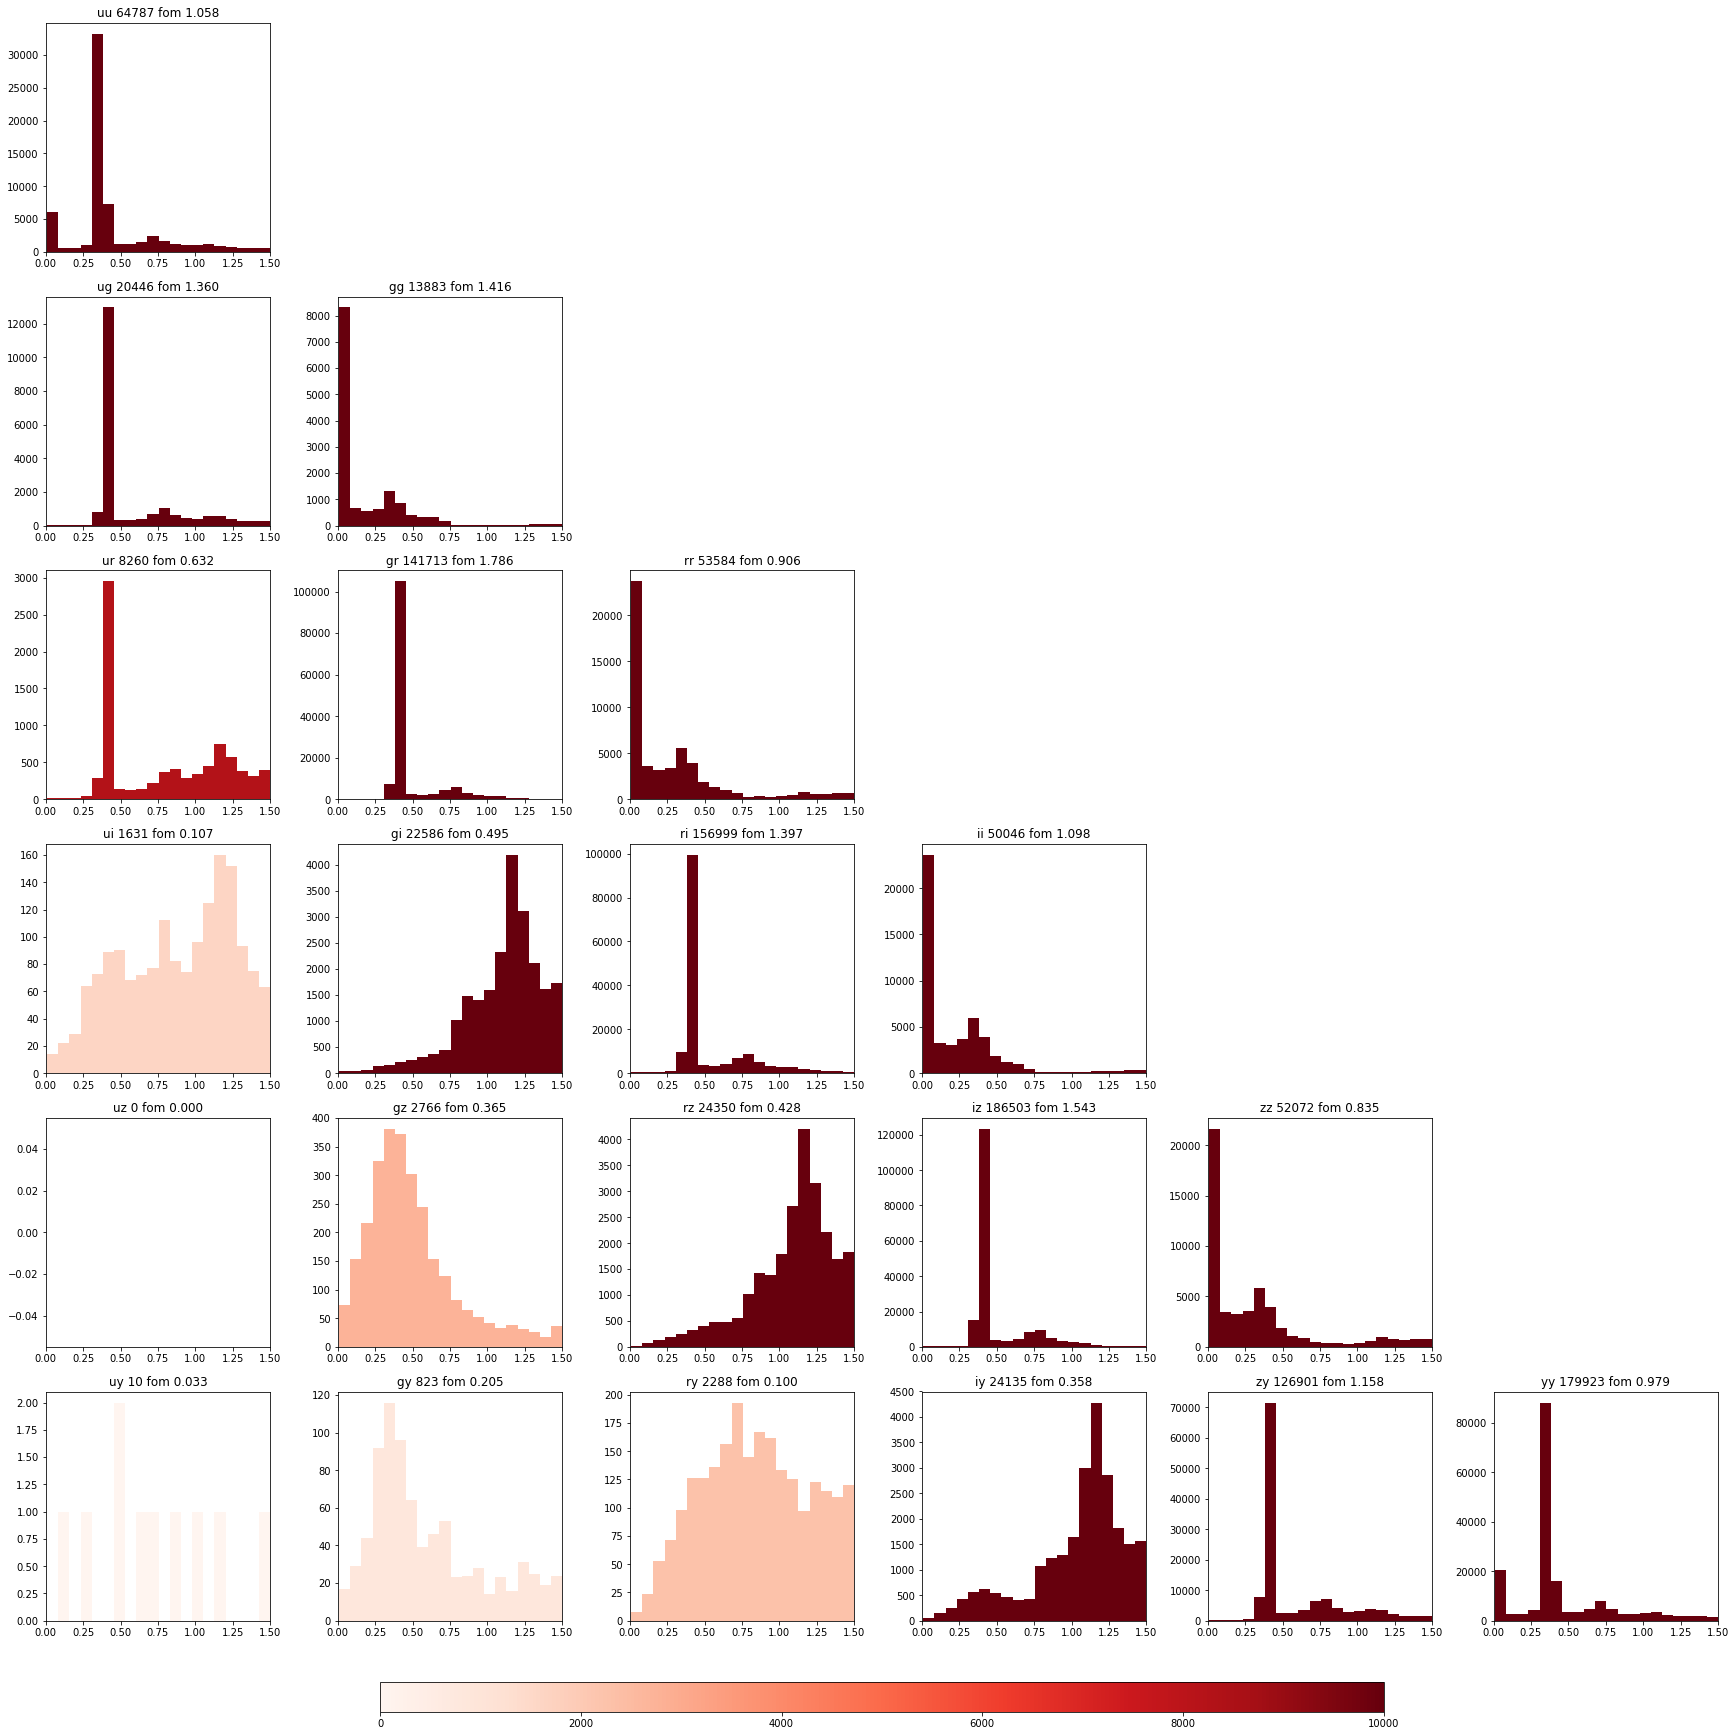

In [22]:
%%time

filename = 'data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1'

# figure of merit, using KL divergence 
plot_hist_FOM(filename=filename, night=[0,4000], tmin=0, tmax=1.5, vmax=10000, bins=20 )


loaded  data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1
CPU times: user 2min 5s, sys: 3.73 s, total: 2min 9s
Wall time: 2min 9s


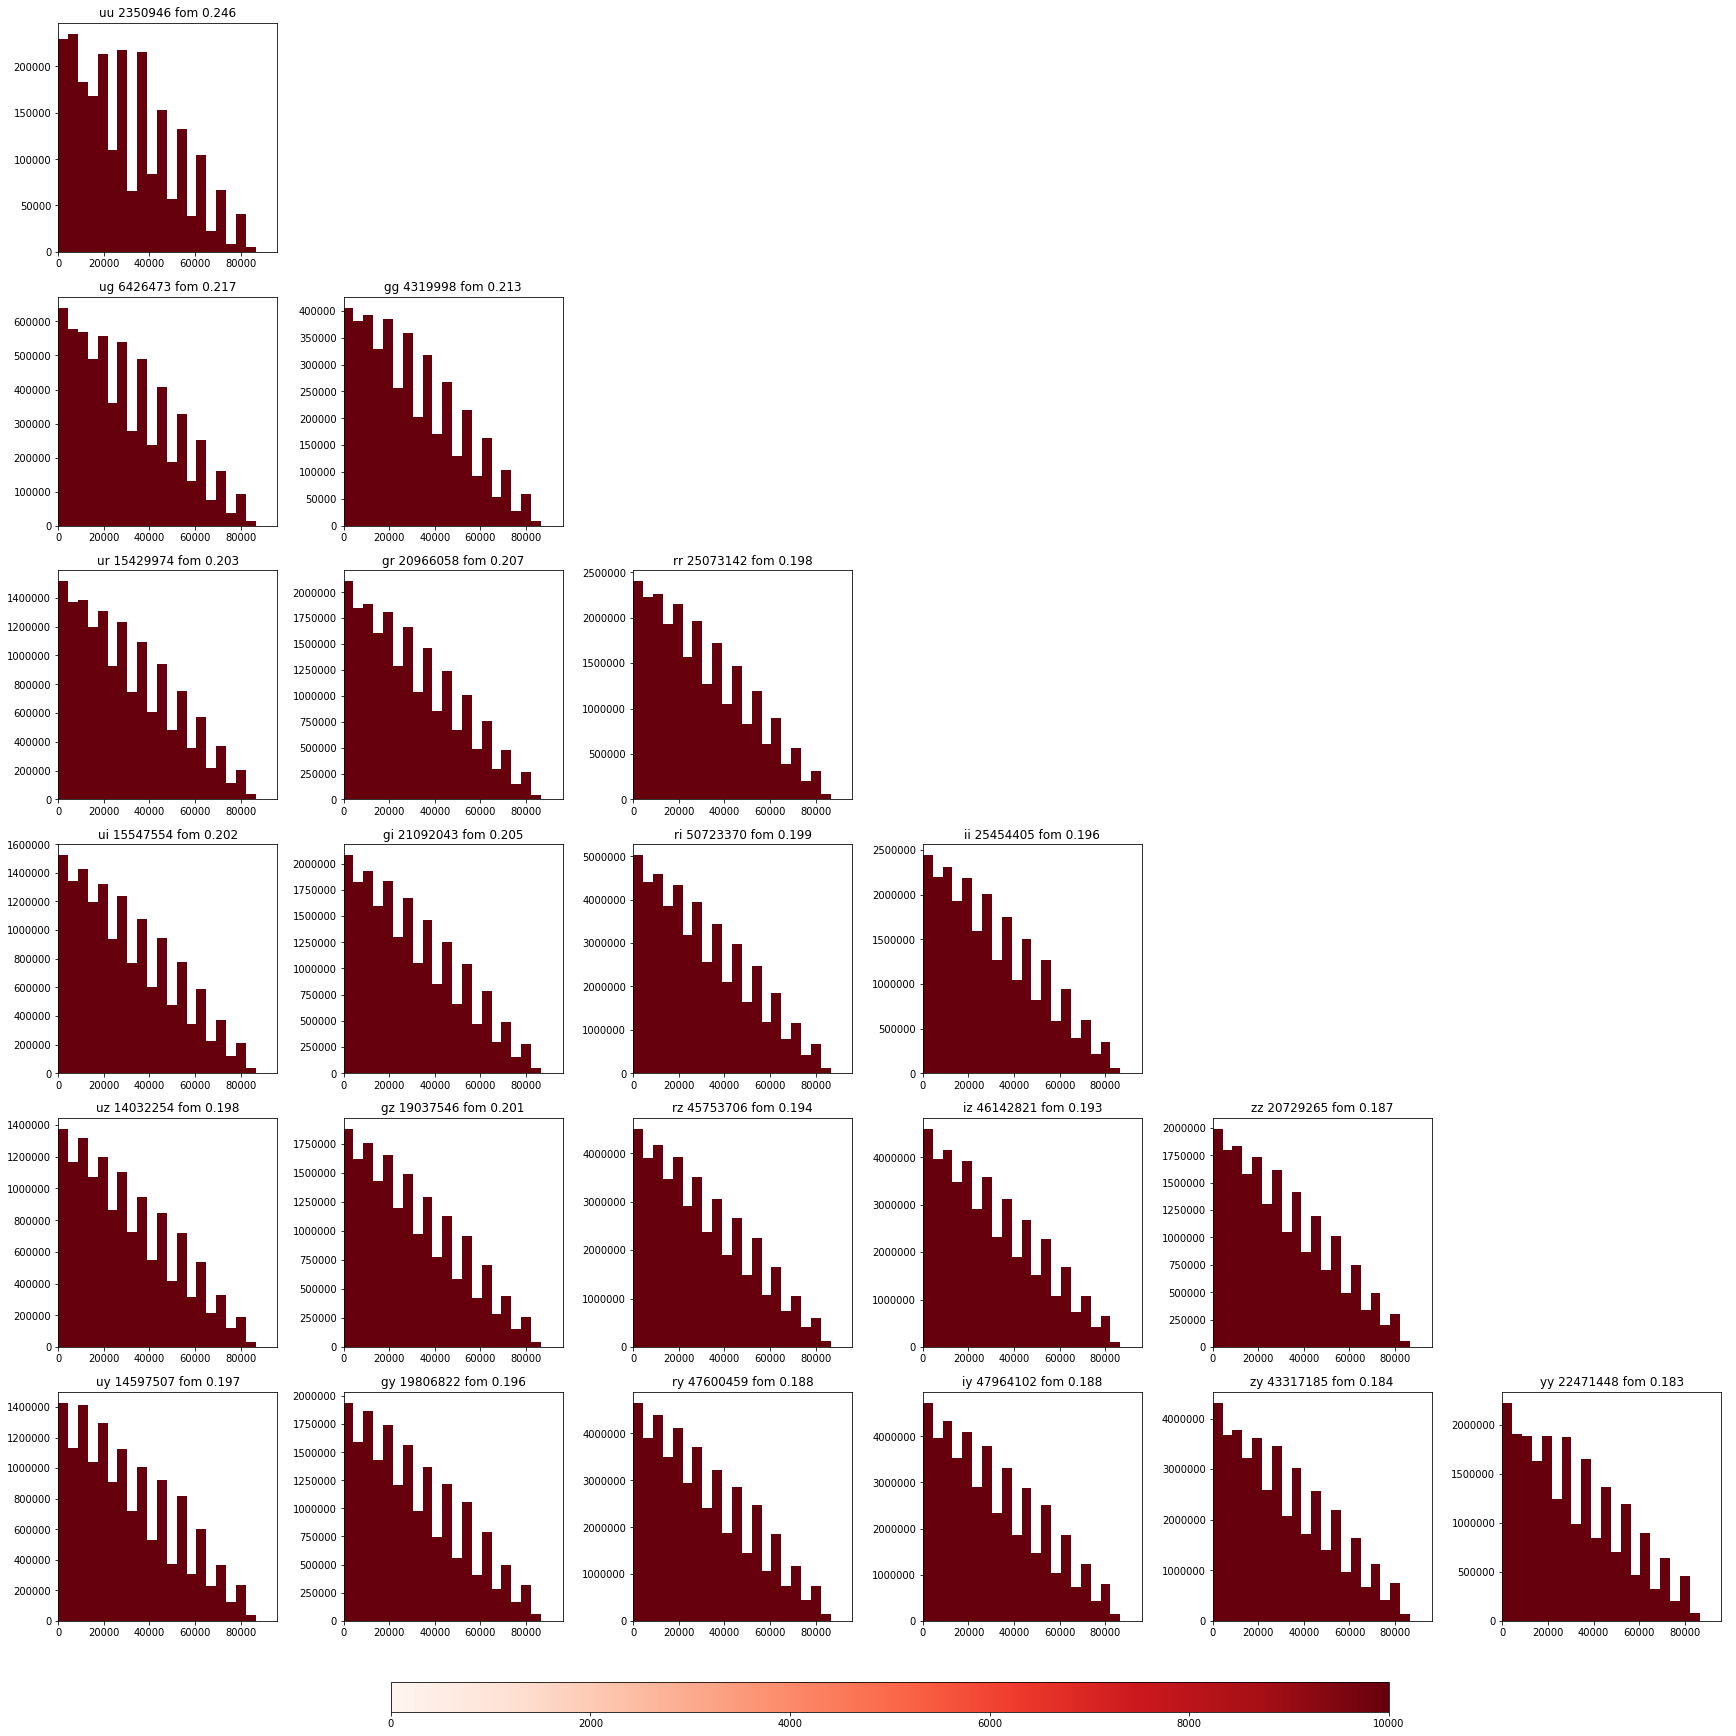

In [23]:
%%time

filename = 'data/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1'

# figure of merit, using KL divergence 
plot_hist_FOM(filename=filename, night=[0,4000], tmin=0, tmax=24*4000, vmax=10000, bins=20 )


In [24]:
def plot_hist_FOM_samefilter(filename='', night=[0,400], tmin=0, tmax=1.5, vmax=10000, bins=np.arange(0, 1.6, 0.1) ):
    """plot hist of all possible gaps within tmin~tmax, in hours"""
    #df_dict = load_df_dict(dbname=dbname, DD=DD, nside=nside)
    
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    # calculate dT
    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    
    print('loaded ', filename)
    fig, axs = plt.subplots(6, 1, figsize=(8, 20), constrained_layout=True); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

    ax = axs.ravel()
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()

            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # in hours
                #dT = np.concatenate(df['dT'].values)   # in days
                
                dT_tlim = dT[(dT>tmin)&(dT<tmax)] 
                Ntotal = len(dT_tlim)

                norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
                cmap = matplotlib.cm.Reds
                m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                #values, bins, _ = axs[fdict[f0], fdict[f1]].hist(dT_tlim, bins=bins, color=m.to_rgba(Ntotal) );
                
                values, bins, _ = ax[i].hist( dT_tlim, bins=bins, color=m.to_rgba(Ntotal) );
                
                
                fom = get_FOM(values)

                ax[i].set_title(f0+f1+ ' ' + str(Ntotal) + ' fom %.3f'%(fom) )

                #axs[fdict[f0], fdict[f1]].set_xlabel('dT')
                #ax[i].set_xlim(tmin, tmax)
                ax[i].set_xscale('log')
                ax[i].set_xlabel('Time[Days]')
                
    m.set_array(np.linspace(0, vmax) )            
    #fig.colorbar(mappable=m, ax=axs[:,:], shrink=0.6, location='bottom')

In [327]:
def plot_hist_Dkl(dbfile='', path='', night=[0,400], 
                  tmin=[0, 0], tmax=[1.5, 1.5], 
                  bins=[20, np.arange(0, 1.5, 20)], vmax=10000,
                  xscale = ["linear", "log"]
                 ):
    """
    get figure of merit for opsim, return a single number, 
    tmin, tmax, bins[0] for same filter, 
    tmin, tmax, bins[1] for different filter
    """
    
    filename = path + dbfile
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    # calculate dT
    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    
    print('loaded ', filename)
    fig, axs = plt.subplots(6, 6, figsize=(24, 24), constrained_layout=True); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

    filter_dict = {} 
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()
            
            f0f1 = '{}{}'.format(f0,f1)
            filter_dict[ f0f1 ] = {}
            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24
                
                dT_tlim = dT[(dT>tmin[0])&(dT<tmax[0])] 
                Ntotal = len(dT_tlim)

                norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
                cmap = matplotlib.cm.Reds
                m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                values, bins_, _ = axs[fdict[f0], fdict[f1]].hist(dT_tlim, bins=bins[0], color=m.to_rgba(Ntotal) );
                
                dkl = get_Dkl(values)

                axs[fdict[f1], fdict[f0]].set_title(f0+f1+ ' ' + str(Ntotal) + ' Dkl %.3f'%(dkl) )

                axs[fdict[f0], fdict[f1]].set_xlabel('dT')
                axs[ fdict[f1], fdict[f0] ].set_xlim(tmin[0], tmax[0])
                axs[ fdict[f1], fdict[f0] ].set_xscale(xscale[0])
                
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['dkl'] = dkl
                
                
            else:

                
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # convert to hour
                
                dT_tlim = dT[(dT>tmin[1])&(dT<tmax[1])]

                axs[fdict[f0], fdict[f1]].axis('off')
                """
                axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
                # axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)
                axs[fdict[f1], fdict[f0]].set_title(f0+f1)
                """
                Ntotal = len(dT_tlim)
                norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
                cmap = matplotlib.cm.Reds
                m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                values, bins_, _ = axs[fdict[f1], fdict[f0]].hist(dT_tlim, bins=bins[1], color=m.to_rgba(Ntotal) );
                dkl = get_Dkl(values)
                
                axs[fdict[f1], fdict[f0]].set_title(f0+f1+ ' ' + str(Ntotal) + ' Dkl %.3f'%(dkl) )
                axs[fdict[f1], fdict[f0]].set_xlim(tmin[1], tmax[1])
                axs[ fdict[f1], fdict[f0] ].set_xscale(xscale[1])
                
                # save to dict 
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['dkl'] = dkl

    m.set_array(np.linspace(0, vmax) )            
    fig.colorbar(mappable=m, ax=axs[:,:], shrink=0.6, location='bottom')
    
    fig.suptitle(dbfile, fontsize=16)
    #fig.savefig('{}.png'.format(filename), dpi=200)
    
    return filter_dict



In [110]:
filter_dict_db = {}
filter_dict_db['baseline'] = filter_dict

In [112]:
filter_dict_db['pair_strategy'] = filter_dict

In [116]:
pd.DataFrame(filter_dict_db)

,baseline,pair_strategy
gg,"{'dT': [0.4007704799878411, 1.625632559938822,...","{'dT': [0.4007704799878411, 1.625632559938822,..."
gi,"{'dT': [1.1655369600048289, 1.4970551999285817...","{'dT': [1.1655369600048289, 1.4970551999285817..."
gr,"{'dT': [1.108951440139208, 1.0997848801198415,...","{'dT': [1.108951440139208, 1.0997848801198415,..."
gy,"{'dT': [1.4377980001154356, 1.0727455200394616...","{'dT': [1.4377980001154356, 1.0727455200394616..."
gz,"{'dT': [0.09172535984544083, 0.312171600060537...","{'dT': [0.09172535984544083, 0.312171600060537..."
ii,"{'dT': [8065.021345680056, 8922.809958720056, ...","{'dT': [8065.021345680056, 8922.809958720056, ..."
iy,"{'dT': [0.3710051999660209, 0.8719538400764577...","{'dT': [0.3710051999660209, 0.8719538400764577..."
iz,"{'dT': [0.3880219199345447, 0.4072137600160204...","{'dT': [0.3880219199345447, 0.4072137600160204..."
ri,"{'dT': [0.3908800801145844, 0.3885088800452649...","{'dT': [0.3908800801145844, 0.3885088800452649..."
rr,"{'dT': [0.009166560019366443, 0.01833335997071...","{'dT': [0.009166560019366443, 0.01833335997071..."


In [49]:
bins = [20, 20]

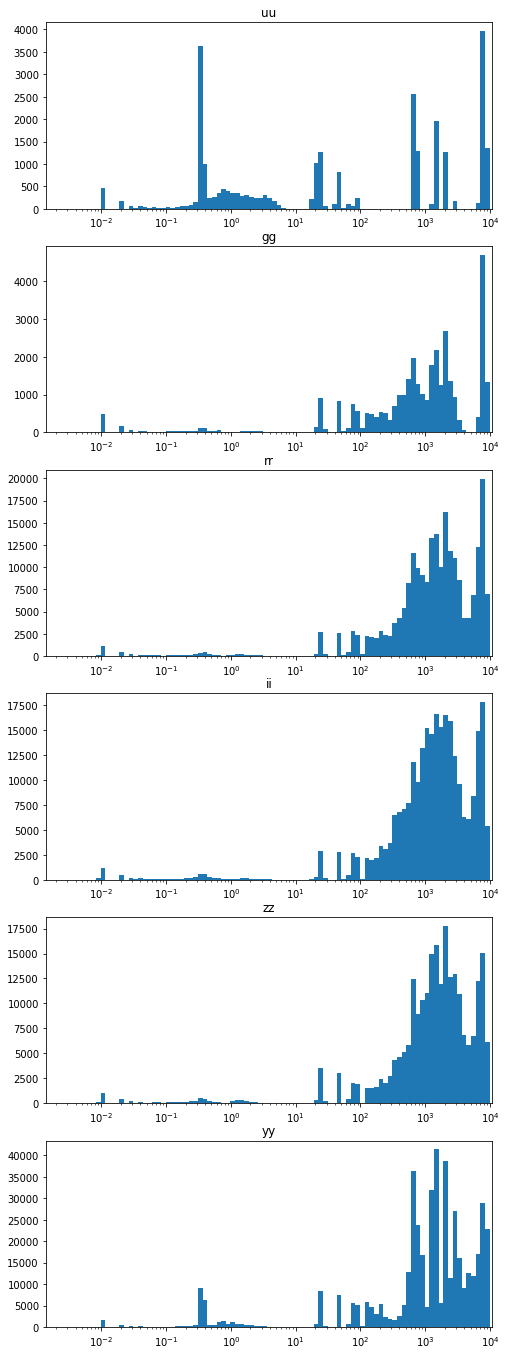

In [95]:
fig, axes = plt.subplots(6, 1, figsize=(8, 24))

for i, f in enumerate(['uu', 'gg', 'rr', 'ii', 'zz', 'yy']):
    dT = filter_dict[f]['dT']
    axes[i].hist(dT, bins=bins_log);
    axes[i].set_title(f)
    axes[i].set_xscale('log')
    axes[i].set_xlim([5/60/60, 450*24])

loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
CPU times: user 44.9 s, sys: 139 ms, total: 45 s
Wall time: 45 s


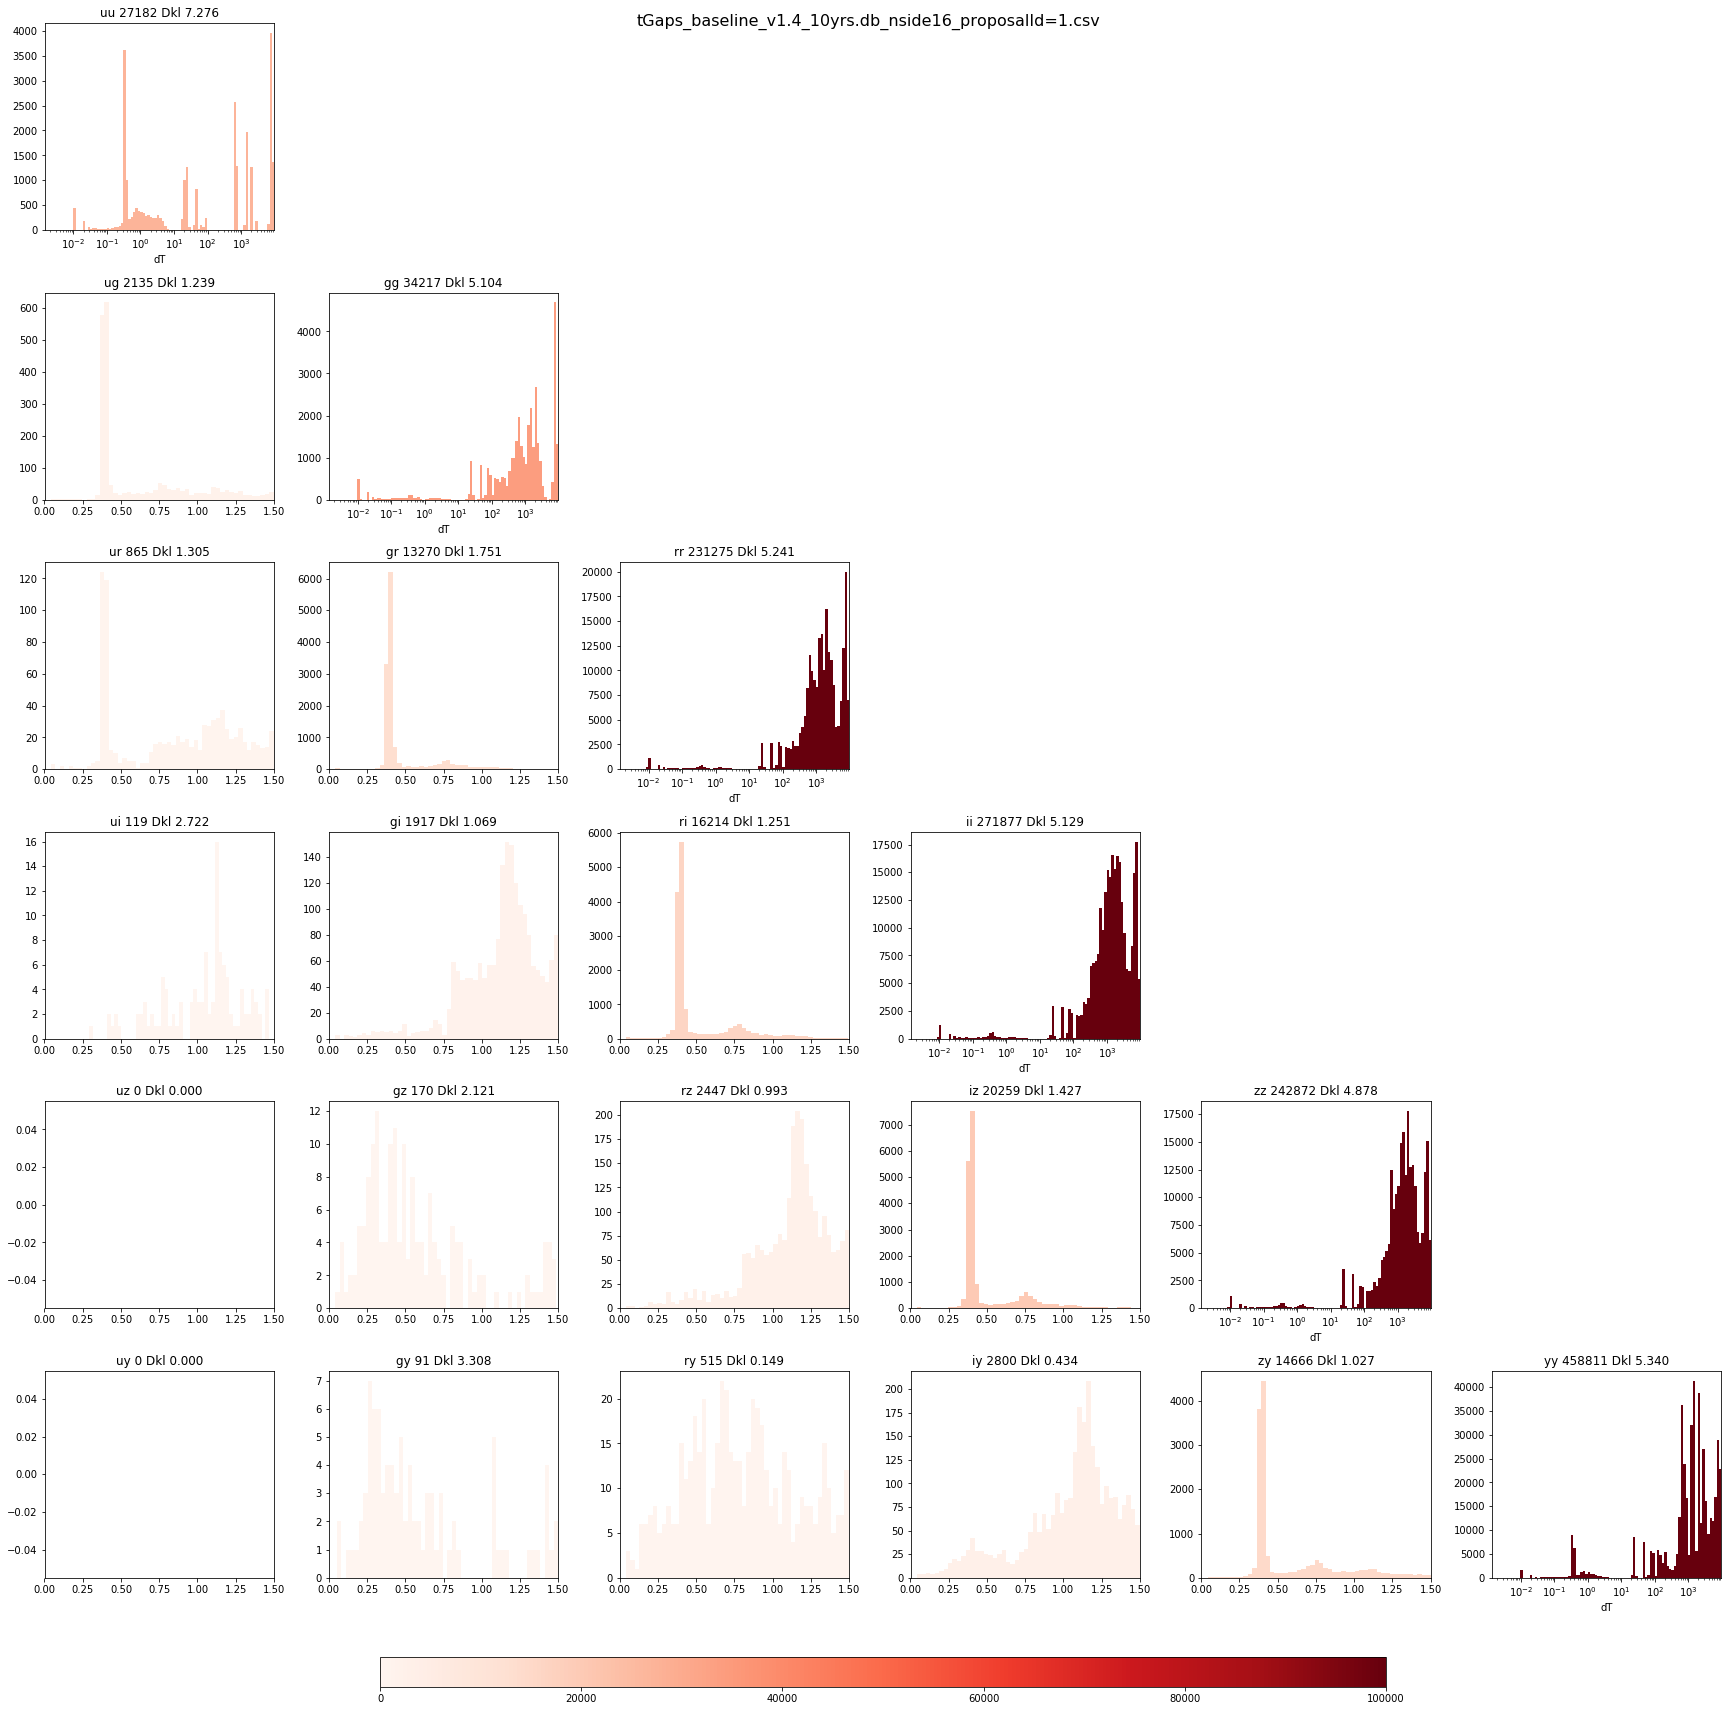

In [328]:
%%time
# 30 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(30.0/60./60.), np.log10(3e8/60./60.), 99)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
filter_dict = plot_hist_Dkl(dbfile=dbfile, path=path , night=[0,400], 
                  tmin=[5/60/60, 5/60/60], tmax=[400*24, 1.5], bins=[bins_log, 50], 
                  vmax=100000, xscale=['log', 'linear'])


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_sat_dodge_v1.4_10yrs.db_nside16_proposalId=1.csv
CPU times: user 49.9 s, sys: 73.5 ms, total: 50 s
Wall time: 50 s


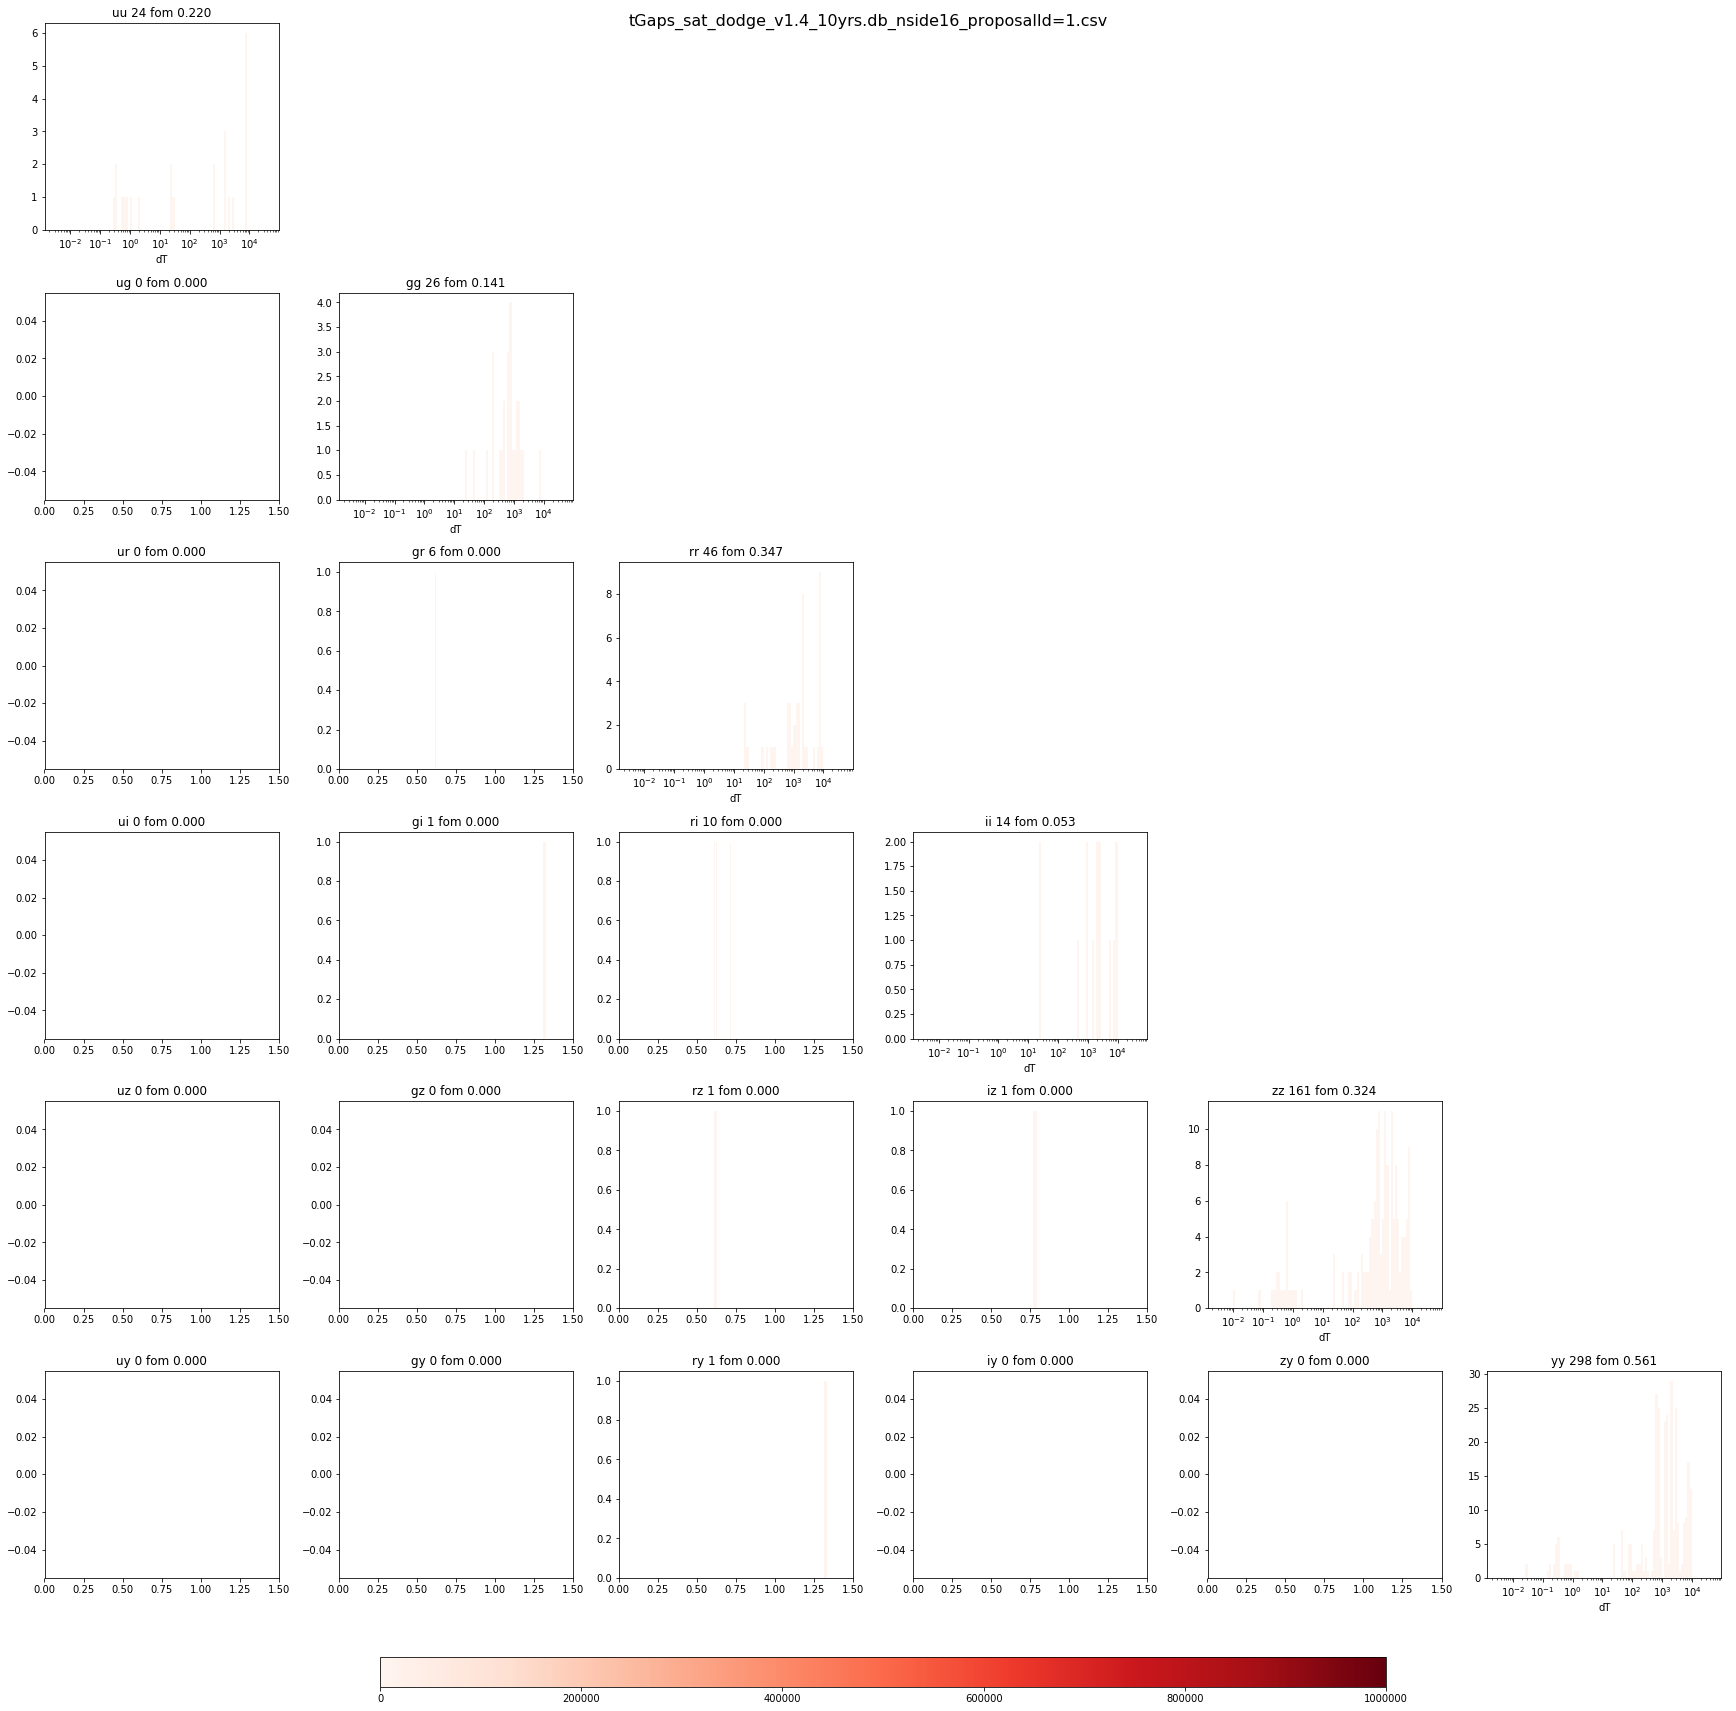

In [200]:
%%time
# 30 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(30.0/60./60.), np.log10(3e8/60./60.), 99)

dbfile = 'tGaps_sat_dodge_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
filter_dict = plot_hist_Dkl(dbfile=dbfile, path=path , night=[0,400], 
                  tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], bins=[bins_log, 50], 
                  vmax=100000, xscale=['log', 'linear'])


In [329]:
def get_hist_dict(dbfile='', path='', night=[0,400], 
                  tmin=[0, 0], tmax=[1.5, 1.5], 
                  bins=[20, np.arange(0, 1.5, 20)] ):
    """
    get figure of merit for opsim, return a single number, 
    tmin, tmax, bins[0] for same filter, 
    tmin, tmax, bins[1] for different filter
    """
    
    filename = path + dbfile
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    # calculate dT
    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    
    print('loaded ', filename)
    flt = ['u', 'g', 'r', 'i', 'z', 'y']

    filter_dict = {} 
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()
            
            f0f1 = '{}{}'.format(f0,f1)
            filter_dict[ f0f1 ] = {}
            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24
                
                dT_tlim = dT[(dT>tmin[0])&(dT<tmax[0])] 
                Ntotal = len(dT_tlim)

                values, bins_ = np.histogram(dT_tlim, bins=bins[0]);
                                
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                
            else:
      
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # convert to hour
                
                dT_tlim = dT[(dT>tmin[1])&(dT<tmax[1])]

    
                Ntotal = len(dT_tlim)
        
                values, bins_ = np.histogram(dT_tlim, bins=bins[1] );

                # save to dict 
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
    
    return filter_dict



In [358]:
def FOM(dbfile=dbfile, path=path , night=[0,400], 
                  tmin=[5/60/60, 5/60/60], tmax=[400*24, 1.5], bins=[bins_log, 50]):

    filter_dict = get_hist_dict(dbfile=dbfile, path=path , night=[0,400], 
                  tmin=[5/60/60, 5/60/60], tmax=[400*24, 1.5], bins=[bins_log, 50])
    
    print('calculating FOM of {}...'.format( dbfile ) )

    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    N_total_same = 0
    N_total_diff = 0
    
    # get total Nvisits for normalization  
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            if f0==f1:
                
                N_total_same += len( filter_dict[key]['dT'] )
                
            else:
                
                N_total_diff += len( filter_dict[key]['dT'] )
    
    # calcuate figure of merit for each filter pair
    fom_same = 0
    fom_diff = 0
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:  
        
            key = '{}{}'.format(f0, f1)
            D = get_Dkl( filter_dict[key]['values'] )
            
            # print('{}{}: Dkl {}'.format(f0, f1, D))
            
            if f0==f1:
                fom_same += len( filter_dict[key]['dT'] ) / N_total_same * np.exp(-D)
                
            else:
                fom_diff  += len( filter_dict[key]['dT'] ) / N_total_diff * np.exp(-D)
            
            # print(key, fom)
                
    return fom_same, fom_diff, N_total_same, N_total_diff


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
CPU times: user 44.4 s, sys: 131 ms, total: 44.5 s
Wall time: 44.5 s


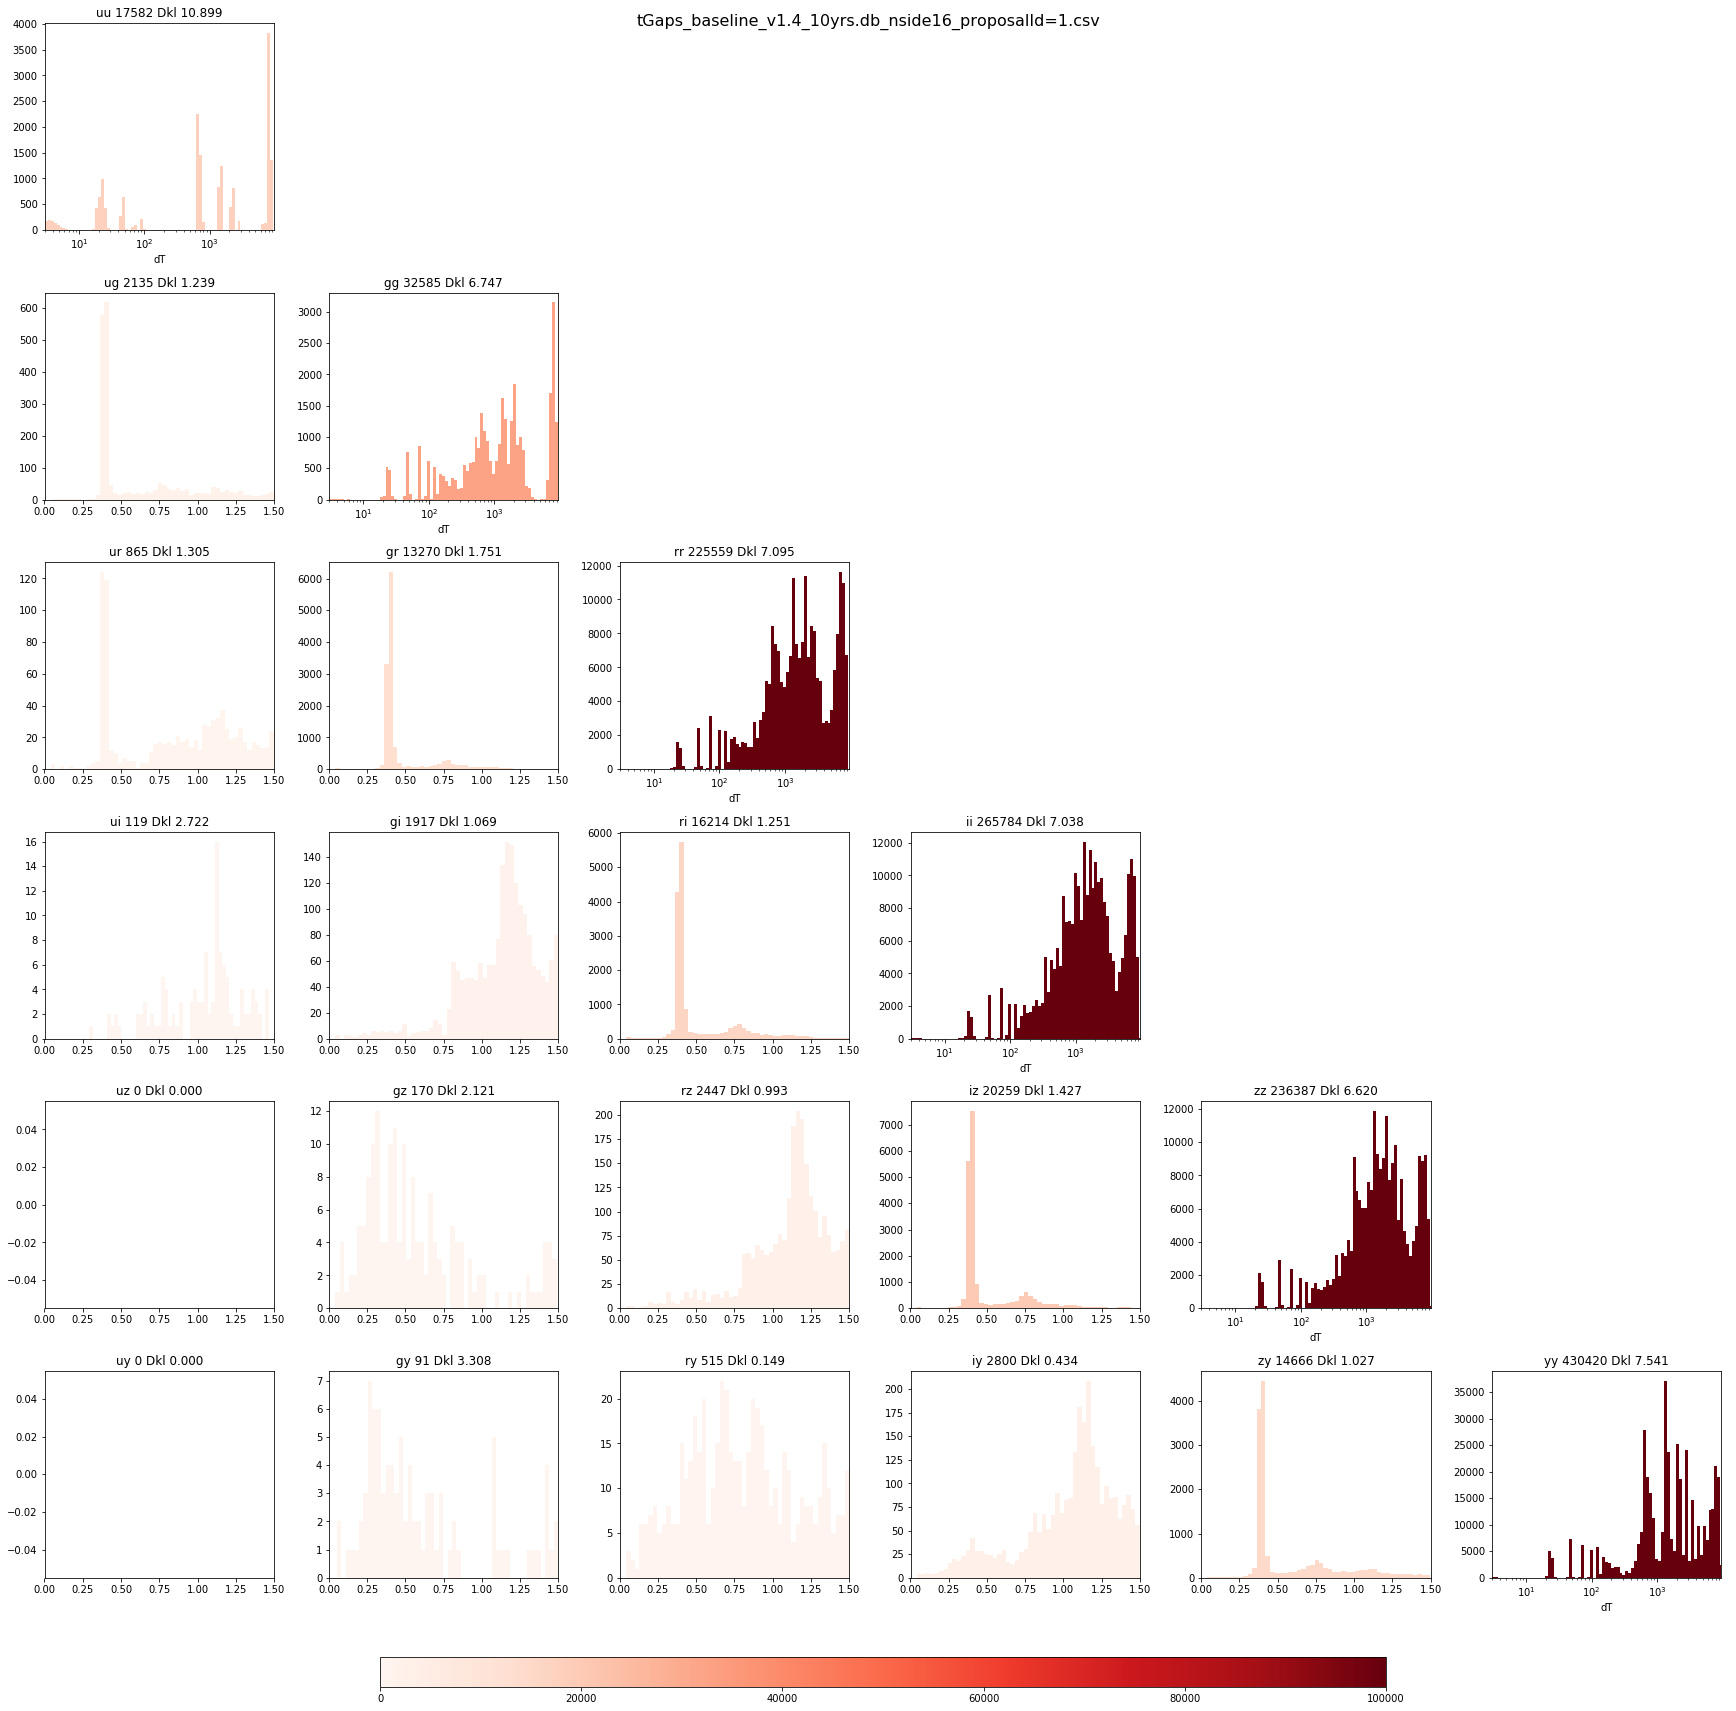

In [340]:
%%time
# 30 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(3), np.log10(3e8/60./60.), 99)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
filter_dict = plot_hist_Dkl(dbfile=dbfile, path=path , night=[0,400], 
                  tmin=[3, 5/60/60], tmax=[400*24, 1.5], bins=[bins_log, 99], 
                  vmax=100000, xscale=['log', 'linear'])


In [355]:
%%time
# 30 hours to 10yrs(~3e8)
bins_log=np.logspace(np.log10(5/60/60), np.log10(3e8/60./60.), 50)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
fom = FOM(dbfile=dbfile, path=path , night=[0,4000], 
                  tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], bins=[bins_log, 50])


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv...
CPU times: user 39.6 s, sys: 56.9 ms, total: 39.7 s
Wall time: 39.7 s


In [357]:
fom

(0.0024716502081377836, 0.2883418532727292, 1266234, 75468)

In [161]:
# run for all opsim dbs 
import glob
dbpath = '/home/idies/workspace/lsst_cadence/FBS_1.4/'
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
dblist_all.sort()
workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'
os.chdir(workpath) # change back to work directory

In [162]:
dblist_all

['agnddf_v1.4_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db',
 'baseline_2snapsv1.4_10yrs.db',
 'baseline_v1.4_10yrs.db',
 'bulges_bs_v1.4_10yrs.db',
 'bulges_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_bs_v1.4_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_i_heavy_v1.4_10yrs.db',
 'bulges_i_heavy_v1.4_10yrs.db',
 'dcr_nham1_v1.4_10yrs.db',
 'dcr_nham2_v1.4_10yrs.db',
 'dcr_nham3_v1.4_10yrs.db',
 'dcr_nham4_v1.4_10yrs.db',
 'dcr_nham5_v1.4_10yrs.db',
 'descddf_v1.4_10yrs.db',
 'euclidddf_v1.4_10yrs.db',
 'footprint_add_mag_cloudsv1.4_10yrs.db',
 'footprint_big_sky_dustv1.4_10yrs.db',
 'footprint_big_sky_nouiyv1.4_10yrs.db',
 'footprint_big_skyv1.4_10yrs.db',
 'footprint_bluer_footprintv1.4_10yrs.db',
 'footprint_gp_smoothv1.4_10yrs.db',
 'footprint_newAv1.4_10yrs.db',
 'footprint_newBv1.4_10yrs.db',
 'footprint_no_gp_northv1.4_10yrs.db',
 'footprint_standard_goalsv1.4_10yrs.db',
 'footprint_stuck_rollingv1.4_10yrs.db',
 'pair_strategy_0_v1.4_10yrs.db',
 

In [363]:
%%time
# calculate fom for all 76 opsims ~50min

# 30 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(3), np.log10(3e8/60./60.), 50)

path = '/home/idies/workspace/Temporary/lixl/scratch/'

fom_all = {}
for dbname in dblist_all:
    dbfile = 'tGaps_{}_nside16_proposalId=1.csv'.format(dbname)
    fom_same, fom_diff, N_total_same, N_total_diff = FOM(dbfile=dbfile, path=path , night=[0,4000], 
                      tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], bins=[bins_log, 50])
    print('FOM of {}: {}, {}'.format( dbname, fom_same, fom_diff) )
    fom_all[dbname] = fom
    
    with open('fom_all_new.csv', 'a') as f:
        f.write("{}, {}, {}, {}, {}\n".format(dbname, fom_same, fom_diff, N_total_same, N_total_diff) )


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_agnddf_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_agnddf_v1.4_10yrs.db_nside16_proposalId=1.csv...
FOM of agnddf_v1.4_10yrs.db: 0.0014172856665603639, 0.30010124408752953
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db_nside16_proposalId=1.csv...
FOM of alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db: 0.0012830400357936311, 0.3490236690114171
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_2snapsv1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_2snapsv1.4_10yrs.db_nside16_proposalId=1.csv...
FOM of baseline_2snapsv1.4_10yrs.db: 0.0012432217404205902, 0.28723548750086036
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_v1.4_10yrs.db_nside1

In [364]:
df = pd.read_csv('fom_all_new.csv', names=['db', 'dkl_same', 'dkl_diff', 'N_same', 'N_diff'])


In [365]:
df['N_same'].sum()

101539871

In [372]:
def scale(arr):
    newarr = ( arr - arr.min() ) / (arr.max() - arr.min() )
    return newarr
    

In [374]:
df['fom_same_final'] = scale(df['dkl_same']) * scale(df['N_same'])

df['fom_diff_final'] = scale(df['dkl_diff']) * scale(df['N_diff'])

In [384]:
df['fom_final'] = df['fom_same_final'] + df['fom_diff_final'] 

In [389]:
df.sort_values(by='fom_same_final', ascending=False)[:10]

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
51,twilight_neo_mod1_v1.4_10yrs.db,0.002324,0.284866,2058600,73280,0.690276,0.282502,0.972779
27,footprint_stuck_rollingv1.4_10yrs.db,0.001610,0.344943,1823424,81976,0.347112,0.382798,0.729910
52,twilight_neo_mod2_v1.4_10yrs.db,0.001651,0.299188,1673768,74746,0.332554,0.302667,0.635222
53,twilight_neo_mod3_v1.4_10yrs.db,0.001526,0.301993,1528334,75875,0.264818,0.310126,0.574943
33,roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,0.001904,0.287158,991481,63219,0.247794,0.245670,0.493464
10,dcr_nham1_v1.4_10yrs.db,0.001616,0.301479,1254231,72161,0.240295,0.294439,0.534733
8,bulges_cadence_i_heavy_v1.4_10yrs.db,0.001985,0.274416,879924,59487,0.234425,0.220888,0.455313
18,footprint_big_sky_dustv1.4_10yrs.db,0.001591,0.295103,1222670,72809,0.227928,0.290790,0.518719
19,footprint_big_sky_nouiyv1.4_10yrs.db,0.001370,0.304561,1551083,88079,0.219652,0.363086,0.582738
73,wfd_depth_scale0.95_v1.4_10yrs.db,0.001469,0.308690,1340882,78840,0.216682,0.329405,0.546088


In [390]:
df.sort_values(by='fom_diff_final', ascending=False)[:10]

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
43,short_exp_5ns_1expt_v1.4_10yrs.db,0.000738,0.232322,2706710,184980,0.035992,0.581460,0.617452
44,short_exp_5ns_5expt_v1.4_10yrs.db,0.001037,0.246958,2460932,170475,0.181817,0.569687,0.751504
58,weather_1.2_ndt_v1.4_10yrs.db,0.000673,0.282252,2894622,117087,0.000000,0.447281,0.447281
41,short_exp_2ns_1expt_v1.4_10yrs.db,0.000928,0.256413,1931638,126816,0.100062,0.440027,0.540089
42,short_exp_2ns_5expt_v1.4_10yrs.db,0.000941,0.268353,1835105,120941,0.100069,0.439217,0.539286
59,weather_1.2_v1.4_10yrs.db,0.000738,0.285560,2571780,111628,0.034052,0.431430,0.465482
55,var_expt_v1.4_10yrs.db,0.001124,0.399208,1283599,77563,0.117630,0.419242,0.536872
74,wfd_depth_scale0.99_noddf_v1.4_10yrs.db,0.001216,0.308231,1685310,92845,0.185759,0.387357,0.573116
27,footprint_stuck_rollingv1.4_10yrs.db,0.001610,0.344943,1823424,81976,0.347112,0.382798,0.729910
72,wfd_depth_scale0.95_noddf_v1.4_10yrs.db,0.001204,0.307376,1656872,91918,0.178669,0.382424,0.561093


In [451]:
df_new = df.sort_values(by='fom_final', ascending=True).reset_index(drop=True)
df_new

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
0,sat_dodge_v1.4_10yrs.db,0.002374,0.000475,569,20,0.000000,0.000000,0.000000
1,pair_strategy_0_v1.4_10yrs.db,0.001206,0.300892,1292709,53438,0.139946,0.217596,0.357543
2,footprint_newAv1.4_10yrs.db,0.001626,0.276355,805036,53984,0.155802,0.201866,0.357669
3,wfd_depth_scale0.65_v1.4_10yrs.db,0.001428,0.269763,908637,62418,0.139200,0.227839,0.367039
4,wfd_depth_scale0.70_noddf_v1.4_10yrs.db,0.000975,0.286517,1194452,77083,0.073371,0.298893,0.372264
5,bulges_bs_v1.4_10yrs.db,0.001509,0.280619,907801,58973,0.154153,0.223937,0.378090
6,bulges_cadence_bs_v1.4_10yrs.db,0.001501,0.281057,910169,59222,0.152983,0.225235,0.378217
7,pair_strategy_2_v1.4_10yrs.db,0.001217,0.316717,1283754,55469,0.141797,0.237768,0.379566
8,pair_strategy_3_v1.4_10yrs.db,0.001223,0.312768,1307803,55538,0.146138,0.235091,0.381229
9,baseline_2snapsv1.4_10yrs.db,0.001243,0.287235,1076680,67505,0.124664,0.262402,0.387065


In [457]:
len(pos)

76

In [467]:
plt.style.use('seaborn')


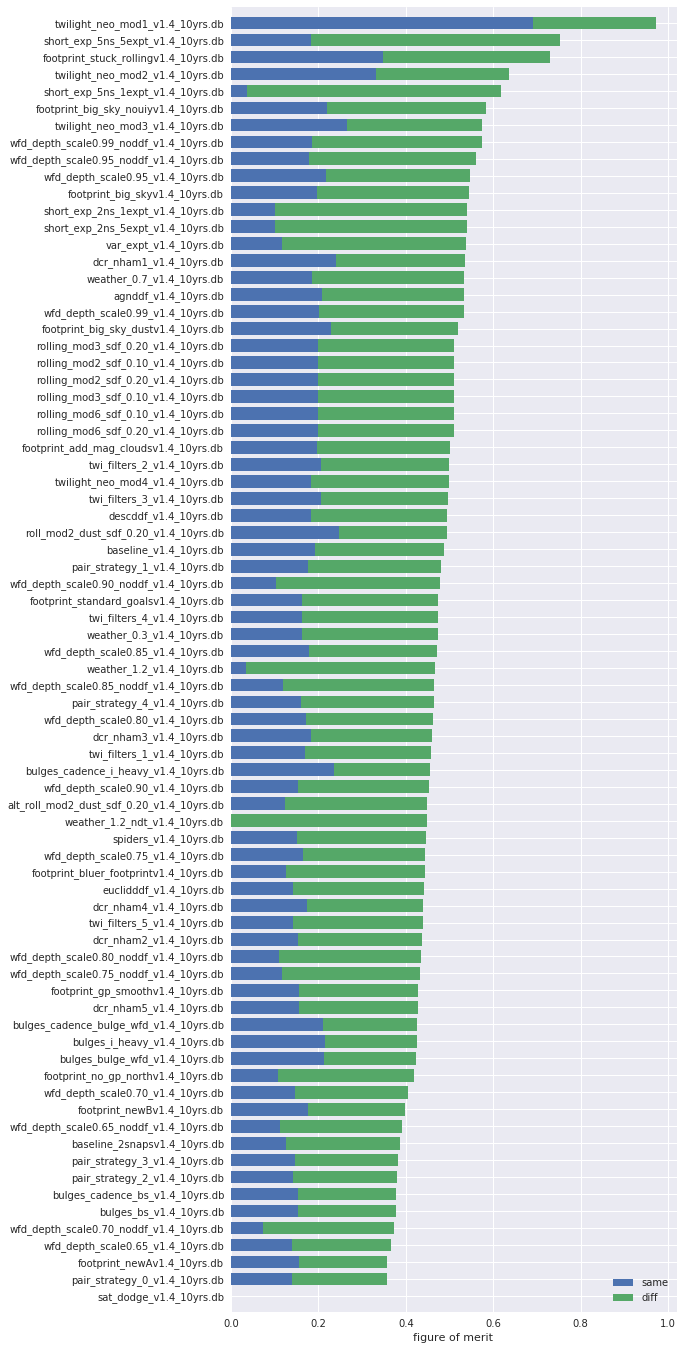

In [469]:
plt.figure(figsize=(8,24))

labels = df_new.db.values
fom_same = df_new.fom_same_final.values
fom_diff = df_new.fom_diff_final.values

width = 0.2
pos = np.linspace(0, 20, 76)
plt.barh(pos, fom_same, width, label='same', align='center')
plt.barh(pos, fom_diff, width, left=fom_same, label='diff')

plt.yticks(pos, labels)
plt.xlabel('figure of merit ')
plt.ylim([-.25, 20.25])
plt.legend()

In [421]:
df.sort_values(by='fom_final', ascending=False)[:10]

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
51,twilight_neo_mod1_v1.4_10yrs.db,0.002324,0.284866,2058600,73280,0.690276,0.282502,0.972779
44,short_exp_5ns_5expt_v1.4_10yrs.db,0.001037,0.246958,2460932,170475,0.181817,0.569687,0.751504
27,footprint_stuck_rollingv1.4_10yrs.db,0.001610,0.344943,1823424,81976,0.347112,0.382798,0.729910
52,twilight_neo_mod2_v1.4_10yrs.db,0.001651,0.299188,1673768,74746,0.332554,0.302667,0.635222
43,short_exp_5ns_1expt_v1.4_10yrs.db,0.000738,0.232322,2706710,184980,0.035992,0.581460,0.617452
19,footprint_big_sky_nouiyv1.4_10yrs.db,0.001370,0.304561,1551083,88079,0.219652,0.363086,0.582738
53,twilight_neo_mod3_v1.4_10yrs.db,0.001526,0.301993,1528334,75875,0.264818,0.310126,0.574943
74,wfd_depth_scale0.99_noddf_v1.4_10yrs.db,0.001216,0.308231,1685310,92845,0.185759,0.387357,0.573116
72,wfd_depth_scale0.95_noddf_v1.4_10yrs.db,0.001204,0.307376,1656872,91918,0.178669,0.382424,0.561093
73,wfd_depth_scale0.95_v1.4_10yrs.db,0.001469,0.308690,1340882,78840,0.216682,0.329405,0.546088


In [424]:
df.db[51]

'twilight_neo_mod1_v1.4_10yrs.db'

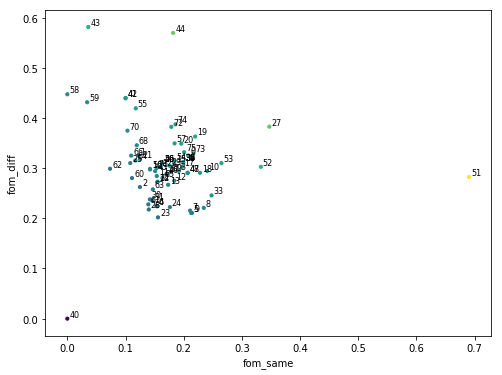

In [423]:
plt.figure(figsize=(8,6))
x = df.fom_same_final
y = df.fom_diff_final
plt.scatter(x=x, y=y, s=10, c=x+y)
plt.xlabel('fom_same')
plt.ylabel('fom_diff')
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), xytext=(2, 2), textcoords='offset points', fontsize=8)


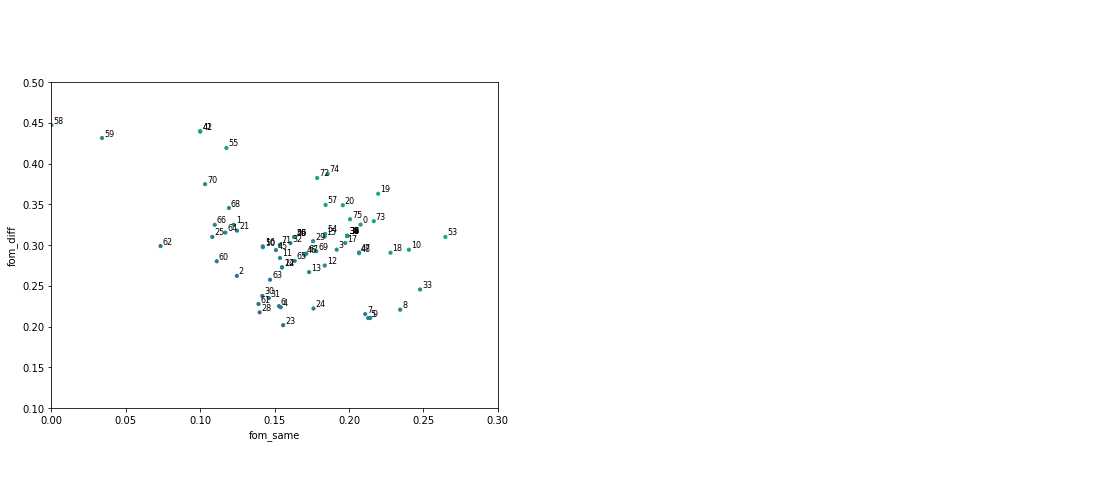

In [425]:
plt.figure(figsize=(8,6))
x = df.fom_same_final
y = df.fom_diff_final
plt.scatter(x=x, y=y, s=10, c=x+y)
plt.xlabel('fom_same')
plt.ylabel('fom_diff')
plt.xlim([0, 0.3])
plt.ylim([0.1, 0.5])
for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), xytext=(2, 2), textcoords='offset points', fontsize=8)


In [420]:
df.db[40]

'sat_dodge_v1.4_10yrs.db'

In [406]:
df [ df.db.str.contains('roll') ]

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,0.001283,0.349024,989164,68806,0.122522,0.325090,0.447612
27,footprint_stuck_rollingv1.4_10yrs.db,0.001610,0.344943,1823424,81976,0.347112,0.382798,0.729910
33,roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,0.001904,0.287158,991481,63219,0.247794,0.245670,0.493464
34,rolling_mod2_sdf_0.10_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168
35,rolling_mod2_sdf_0.20_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168
36,rolling_mod3_sdf_0.10_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168
37,rolling_mod3_sdf_0.20_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168
38,rolling_mod6_sdf_0.10_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168
39,rolling_mod6_sdf_0.20_v1.4_10yrs.db,0.001464,0.299203,1237860,76888,0.198809,0.311359,0.510168


In [404]:
df [ df.db.str.contains('pair') ]

,db,dkl_same,dkl_diff,N_same,N_diff,fom_same_final,fom_diff_final,fom_final
28,pair_strategy_0_v1.4_10yrs.db,0.001206,0.300892,1292709,53438,0.139946,0.217596,0.357543
29,pair_strategy_1_v1.4_10yrs.db,0.001368,0.296275,1246063,76037,0.175870,0.304894,0.480764
30,pair_strategy_2_v1.4_10yrs.db,0.001217,0.316717,1283754,55469,0.141797,0.237768,0.379566
31,pair_strategy_3_v1.4_10yrs.db,0.001223,0.312768,1307803,55538,0.146138,0.235091,0.381229
32,pair_strategy_4_v1.4_10yrs.db,0.001295,0.300815,1271260,74295,0.160696,0.302480,0.463175


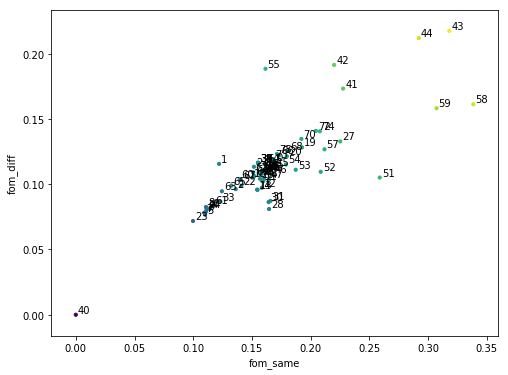

In [246]:
plt.figure(figsize=(8,6))
x = df.fom_same_final
y = df.fom_diff_final
plt.scatter(x=x, y=y, s=10, c=x+y)
plt.xlabel('fom_same')
plt.ylabel('fom_diff')

for i, txt in enumerate(df.index):
    plt.annotate(txt, (x[i], y[i]), xytext=(2, 2), textcoords='offset points')


In [257]:
df.iloc[[28, 30, 31, 43, 44, 58, 59]]

,db,fom_same,fom_diff,N_same,N_diff,fom_same_final,fom_diff_final
28,pair_strategy_0_v1.4_10yrs.db,0.368674,0.280477,1292709,53438,0.164606,0.081004
30,pair_strategy_2_v1.4_10yrs.db,0.370330,0.288017,1283754,55469,0.164199,0.086344
31,pair_strategy_3_v1.4_10yrs.db,0.366819,0.290332,1307803,55538,0.165691,0.087147
43,short_exp_5ns_1expt_v1.4_10yrs.db,0.340232,0.217524,2706710,184980,0.318140,0.217524
44,short_exp_5ns_5expt_v1.4_10yrs.db,0.343656,0.229997,2460932,170475,0.292158,0.211960
58,weather_1.2_ndt_v1.4_10yrs.db,0.338613,0.254767,2894622,117087,0.338613,0.161250
59,weather_1.2_v1.4_10yrs.db,0.345878,0.262209,2571780,111628,0.307294,0.158221


In [197]:
for i in df['fom']:
    print(i)

0.3146218325223831
0.33268881378745385
0.3172132992683563
0.3115707168426481
0.30933876273658456
0.30319973730593186
0.3107881076451807
0.3050310432922483
0.3105354195274955
0.30711861892267456
0.3120155611749559
0.3167902009369109
0.31405161832465006
0.3164789270656243
0.31901578954983395
0.3111532646807369
0.3143897462355649
0.3158286093801164
0.3108172577388737
0.31395198205878355
0.3149967682164345
0.3107847631968445
0.3087700611847406
0.3023004117688217
0.3093687760937188
0.3152709421120303
0.314872207302586
0.327665838195522
0.3238969701068171
0.31366392687326383
0.3278159742376994
0.3277973038437024
0.3108784297757965
0.30588935479796536
0.3200935581596508
0.3200935581596508
0.3200935581596508
0.3200935581596508
0.3200935581596508
0.3200935581596508
0.8287288272573079
0.3096990953730725
0.3324101684541533
0.2933049733526122
0.3022802459797129
0.3184551641460598
0.3027324570476078
0.3085510136993137
0.3075097446097164
0.314872207302586
0.3150470930627244
0.3293812008843396
0.3295

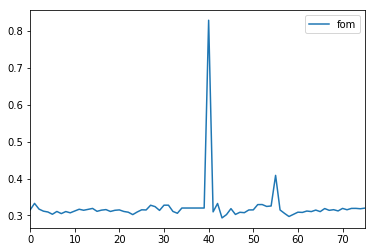

In [196]:
df.plot()

In [177]:
fom_all

{'agnddf_v1.4_10yrs.db': 0.3146218325223831,
 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db': 0.33268881378745385,
 'baseline_2snapsv1.4_10yrs.db': 0.3172132992683563,
 'baseline_v1.4_10yrs.db': 0.3115707168426481,
 'bulges_bs_v1.4_10yrs.db': 0.30933876273658456,
 'bulges_bulge_wfd_v1.4_10yrs.db': 0.30319973730593186,
 'bulges_cadence_bs_v1.4_10yrs.db': 0.3107881076451807,
 'bulges_cadence_bulge_wfd_v1.4_10yrs.db': 0.3050310432922483,
 'bulges_cadence_i_heavy_v1.4_10yrs.db': 0.31053541952749547,
 'bulges_i_heavy_v1.4_10yrs.db': 0.30711861892267456,
 'dcr_nham1_v1.4_10yrs.db': 0.3120155611749559,
 'dcr_nham2_v1.4_10yrs.db': 0.3167902009369109,
 'dcr_nham3_v1.4_10yrs.db': 0.31405161832465,
 'dcr_nham4_v1.4_10yrs.db': 0.3164789270656243,
 'dcr_nham5_v1.4_10yrs.db': 0.31901578954983395,
 'descddf_v1.4_10yrs.db': 0.31115326468073695,
 'euclidddf_v1.4_10yrs.db': 0.3143897462355649,
 'footprint_add_mag_cloudsv1.4_10yrs.db': 0.31582860938011637,
 'footprint_big_sky_dustv1.4_10yrs.db': 0.310817257

In [181]:
fom_all

{'agnddf_v1.4_10yrs.db': 0.3146218325223831,
 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db': 0.33268881378745385,
 'baseline_2snapsv1.4_10yrs.db': 0.3172132992683563,
 'baseline_v1.4_10yrs.db': 0.3115707168426481,
 'bulges_bs_v1.4_10yrs.db': 0.30933876273658456,
 'bulges_bulge_wfd_v1.4_10yrs.db': 0.30319973730593186,
 'bulges_cadence_bs_v1.4_10yrs.db': 0.3107881076451807,
 'bulges_cadence_bulge_wfd_v1.4_10yrs.db': 0.3050310432922483,
 'bulges_cadence_i_heavy_v1.4_10yrs.db': 0.31053541952749547,
 'bulges_i_heavy_v1.4_10yrs.db': 0.30711861892267456,
 'dcr_nham1_v1.4_10yrs.db': 0.3120155611749559,
 'dcr_nham2_v1.4_10yrs.db': 0.3167902009369109,
 'dcr_nham3_v1.4_10yrs.db': 0.31405161832465,
 'dcr_nham4_v1.4_10yrs.db': 0.3164789270656243,
 'dcr_nham5_v1.4_10yrs.db': 0.31901578954983395,
 'descddf_v1.4_10yrs.db': 0.31115326468073695,
 'euclidddf_v1.4_10yrs.db': 0.3143897462355649,
 'footprint_add_mag_cloudsv1.4_10yrs.db': 0.31582860938011637,
 'footprint_big_sky_dustv1.4_10yrs.db': 0.310817257

In [186]:
df = pd.DataFrame(fom_all, index=[0])
df

,agnddf_v1.4_10yrs.db,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,baseline_2snapsv1.4_10yrs.db,baseline_v1.4_10yrs.db,bulges_bs_v1.4_10yrs.db,bulges_bulge_wfd_v1.4_10yrs.db,bulges_cadence_bs_v1.4_10yrs.db,bulges_cadence_bulge_wfd_v1.4_10yrs.db,bulges_cadence_i_heavy_v1.4_10yrs.db,bulges_i_heavy_v1.4_10yrs.db,...,wfd_depth_scale0.80_noddf_v1.4_10yrs.db,wfd_depth_scale0.80_v1.4_10yrs.db,wfd_depth_scale0.85_noddf_v1.4_10yrs.db,wfd_depth_scale0.85_v1.4_10yrs.db,wfd_depth_scale0.90_noddf_v1.4_10yrs.db,wfd_depth_scale0.90_v1.4_10yrs.db,wfd_depth_scale0.95_noddf_v1.4_10yrs.db,wfd_depth_scale0.95_v1.4_10yrs.db,wfd_depth_scale0.99_noddf_v1.4_10yrs.db,wfd_depth_scale0.99_v1.4_10yrs.db
0,0.314622,0.332689,0.317213,0.311571,0.309339,0.3032,0.310788,0.305031,0.310535,0.307119,...,0.318691,0.313872,0.315586,0.312247,0.319061,0.315413,0.319067,0.319127,0.318121,0.319839


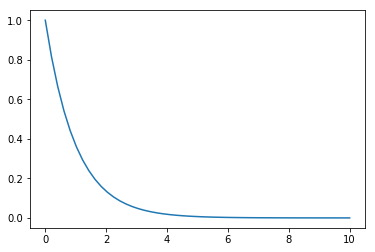

In [107]:
x = np.linspace(0, 10)
y = np.exp(-x)
plt.plot(x, y)